# week 4
청원 주제 분류하는 FINE-TUNE TASK

In [1]:
device = 'cuda'
with open('../data/petitions_2019-01.txt', 'r') as f:
    corpus = f.readlines()
json_list = [eval(json.strip()) for json in corpus]
corpus = [(json['content'], json['category']) for json in json_list]

# base line

# data preprocess

In [2]:
import re
import mecab
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import torchtext
import sys
sys.path.append('../source')
from dataset import *
from txt_cleaner.clean.master import MasterCleaner
from txt_cleaner.utils import *
from torch8text.data import Vocab, Field, LabelField
from torch.utils.data import Dataset, DataLoader


In [3]:
config = read_yaml('../config.yaml')
petition_ds = PetitionDataset_finetune(config)
petition_ds = petition_ds(corpus)

{'MINIMUM_SPACE_COUNT': 2, 'TOKEN_MAX_LEN': 40, 'CHR_MAX_LEN': 4, 'BATCH_SIZE': 64, 'TOKEN_MIN_FREQ': 5, 'CHR_MIN_FREQ': 1}
20951 20951


In [46]:
petition_dl = DataLoader(petition_ds, batch_size=4, collate_fn=pad_collate_finetune)

In [ ]:
for _ in dl:
    pass
#     print(_.src_chr.shape)
#     print(_.trg)
#     break

In [ ]:
INPUT_DIM = len(petition_ds.chr_field.vocab.stoi_dict)
OUTPUT_DIM = len(petition_ds.label_field.vocab.stoi_dict)
N_LAYERS = 2
HID_DIM = 512
EMBEDDING_DIM = 1024

In [ ]:
class simpleGRU_model(nn.Module):
    def __init__(self, input_dim, embedding_dim, n_layers, hid_dim, output_dim):
        super(simpleGRU_model, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hid_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x):
        bs = x.shape[0]
        output = self.embedding(x)
        output = output.reshape(bs, -1, self.embedding_dim)
        _, output = self.gru(output)
        output = self.fc(output[-1, :, :])
        return output

In [ ]:
simple_gru = simpleGRU_model(INPUT_DIM, EMBEDDING_DIM, N_LAYERS, HID_DIM, OUTPUT_DIM)

In [ ]:
petition_ds.label_field.vocab.stoi_dict

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_gru.parameters(), lr = config['TRAIN']['LR'])

In [ ]:
for _ in dl:
    output = simple_gru(_.src_chr)
    loss = criterion(output, _.trg)
    loss.backward()
    optimizer.step()
    break

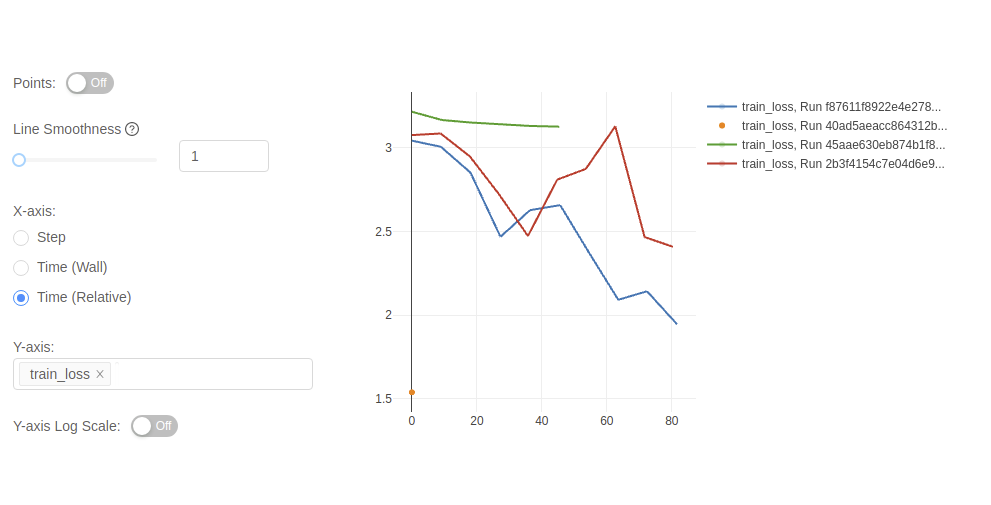

# pretrained model loading 

In [11]:
PATH = '/home/long8v/torch_study/paper/05_ELMo/source/lightning_logs/version_55/checkpoints/epoch=34-step=85224.ckpt'


In [6]:
import mlflow
from utils import *
from model import *
from dataset import *
from torch8text import *
import torch
from utils import *
from model import *
from dataset import *
from torch8text import *

In [7]:
config_file = '/home/long8v/torch_study/paper/05_ELMo/config.yaml'
config = read_yaml(config_file)

In [8]:
with open('../data/petitions.p', 'rb') as f:
    corpus = pickle.load(f)

In [9]:
config = config
ds = PetitionDataset(config)
ds = ds(corpus)
dl = DataLoader(ds, config['DATA']['BATCH_SIZE'], collate_fn=pad_collate)

chr_vocab_size = len(ds.chr_field.vocab)
chr_pad_idx = ds.chr_field.vocab.stoi_dict['<PAD>']
trg_pad_idx = ds.token_field.vocab.stoi_dict['<PAD>']
predict_dim = len(ds.token_field.vocab) 
elmo = ELMo(config, chr_vocab_size, chr_pad_idx, trg_pad_idx, predict_dim)

{'MINIMUM_SPACE_COUNT': 2, 'TOKEN_MAX_LEN': 40, 'CHR_MAX_LEN': 4, 'BATCH_SIZE': 64, 'TOKEN_MIN_FREQ': 5, 'CHR_MIN_FREQ': 1}
cnn_output_dim 30


In [12]:
model = elmo
optimizer, _ = elmo.configure_optimizers()

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']

In [13]:
model.eval()
query = '저는 억울합니다. 제가 바로 이 땅의 주인입니다. 반갑습니다.'
token_query = petition_ds.token_field.preprocess(query)
print(token_query)
chr_token_query = petition_ds.chr_field.preprocess(token_query)
print(chr_token_query)
processed_query = petition_ds.chr_field.pad_process(chr_token_query, max_len=40)

['저', '는', '억울', '합니다', '.', '제', '가', '바로', '이', '땅', '의', '주인', '입니다', '.', '반갑', '습니다', '.']
[['저'], ['는'], ['억', '울'], ['합', '니', '다'], ['.'], ['제'], ['가'], ['바', '로'], ['이'], ['땅'], ['의'], ['주', '인'], ['입', '니', '다'], ['.'], ['반', '갑'], ['습', '니', '다'], ['.']]


# elmo + fine-tune task

In [28]:
INPUT_DIM = len(ds.chr_field.vocab.stoi_dict)
OUTPUT_DIM = len(petition_ds.label_field.vocab.stoi_dict)
N_LAYERS = 2
HID_DIM = 512
EMBEDDING_DIM = 1024

In [49]:
class simpleGRU_model_w_elmo(nn.Module):
    def __init__(self, elmo, input_dim, embedding_dim, n_layers, hid_dim, output_dim):
        super(simpleGRU_model_w_elmo, self).__init__()
        self.elmo = elmo
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hid_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x):
        bs = x.shape[0]
        with torch.no_grad():
            forward_elmo_vector, _ = elmo.forward(x, finetune=True)
        forward_elmo_vector.reshape(bs, -1, )
#         print(forward_elmo_vector.shape)
        elmo_vector = torch.sum(forward_elmo_vector, dim = -1)
#         print(elmo_vector.shape)
        output = self.embedding(x)
#         print(output.shape)
        output = output.reshape(bs, -1, self.embedding_dim)
        _, output = self.gru(output)
        output = self.fc(output[-1, :, :])
        return output

In [50]:
simple_elmo_gru = simpleGRU_model_w_elmo(elmo, INPUT_DIM, EMBEDDING_DIM, N_LAYERS, HID_DIM, OUTPUT_DIM)

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_elmo_gru.parameters(), lr = config['TRAIN']['LR'])

In [ ]:
for batch in petition_dl:
    src, trg = batch.src_chr, batch.trg
    output =  simple_elmo_gru(src)
    loss = criterion(output, trg)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(2.7780, grad_fn=<NllLossBackward>)
tensor(3.8591, grad_fn=<NllLossBackward>)
tensor(2.5111, grad_fn=<NllLossBackward>)
tensor(3.2065, grad_fn=<NllLossBackward>)
tensor(3.4986, grad_fn=<NllLossBackward>)
tensor(3.8075, grad_fn=<NllLossBackward>)
tensor(3.6352, grad_fn=<NllLossBackward>)
tensor(3.4029, grad_fn=<NllLossBackward>)
tensor(2.1169, grad_fn=<NllLossBackward>)
tensor(2.8552, grad_fn=<NllLossBackward>)
tensor(4.1784, grad_fn=<NllLossBackward>)
tensor(4.2971, grad_fn=<NllLossBackward>)
tensor(3.7761, grad_fn=<NllLossBackward>)
tensor(3.4913, grad_fn=<NllLossBackward>)
tensor(2.3346, grad_fn=<NllLossBackward>)
tensor(1.8144, grad_fn=<NllLossBackward>)
tensor(3.5472, grad_fn=<NllLossBackward>)


In [38]:
OUTPUT_DIM

17